In [1]:
import pandas as pd
from convergence.plotting import plot_faverage_parcelation, add_area_labels
from pathlib import Path

clusters = {
    'Visual Cortex': ["V1", "V2", "V3", "V4"],
    'Ventral Hub': ["VMV1", "VMV2", "VMV3", "PHA1", "PHA2", "PHA3"],
    "Dorsal Hub": ["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"],
}

output = Path("figures_other_datasets")
output.mkdir(exist_ok=True)

In [2]:
def load_file(dataset="bold5000", kind="subject", joined=True):
    joined_suffix = "joined" if joined else "separated"
    filename = f"rsa_{dataset}_subject_{kind}_alignment_{joined_suffix}.parquet"
    df = pd.read_parquet(f"data/data_other_datasets/{filename}")
    return df


In [33]:

hcp = pd.read_csv("data/hcp3.csv")
dataset = "bold5000-coco"
df = load_file(dataset, "subject", joined=False).query("roi_x == roi_y and subject_i != subject_j").rename(columns={"roi_x": "roi", "similarity": "score"})
df = df.groupby(["roi", "subject_i"]).score.mean().reset_index()
df = df.groupby("roi").score.mean().reset_index()
# in things dataset For an error in the mask, hemispheres are inverted -> 1-180 -> 180-360 and 180-360 -> 1-180
if dataset == "things":
    df["roi"] = df["roi"].apply(lambda x: x - 180 if x > 180 else x + 180)
df = df.merge(hcp[["roi", "name", "mne_name"]], on="roi")
df

# Add clusters based on name column
hcp["cluster"] = hcp["name"].apply(lambda x: next((k for k, v in clusters.items() if x in v), "Other"))
hcp["area"] = hcp["cluster"]
# Translate clusters to 0, 1, 2 or -1
hcp["area_id"] = hcp["cluster"].apply(lambda x: 0 if x == "Visual Cortex" else (1 if x == "Ventral Hub" else (2 if x == "Dorsal Hub" else -1)))

print(df.score.round(2).min(), df.score.round(2).max())

vmin, vmax = 0.00, 0.1


for hemisphere in ["lh", "rh"]:
    brain = plot_faverage_parcelation(df, normalize=(vmin, vmax), hemisphere=hemisphere)
    add_area_labels(brain, hcp,area_ids=[0, 1, 2], hemispheres=["lh", "rh"] if hemisphere == "both" else [hemisphere])

    for view in ["lateral", "ventral", "caudal"]:
        brain.show_view(view)
        brain.save_image(output / f"{dataset}_{hemisphere}_{view}_{abs(vmin):.2f}_{vmax:.2f}.png", mode="rgba")
    brain.close()


brain = plot_faverage_parcelation(df, normalize=(vmin, vmax))
add_area_labels(brain, hcp,area_ids=[0, 1, 2])
brain.show()

-0.01 0.16


Context leak detected, msgtracer returned -1


In [31]:
modality = "vision"
df_models = load_file(dataset, "model", joined=False)
df_models = df_models.groupby(["roi", "model", "subject", "session"]).similarity.max().reset_index()
df_models = df_models.groupby(["roi", "subject", "model"]).similarity.mean().reset_index()
df_models["modality"] = df_models["model"].str.startswith("vit").map({True: "vision", False: "language"})
df_models = df_models.groupby(["roi", "subject", "modality"]).similarity.mean().reset_index()
df_models = df_models.groupby(["roi", "modality"]).similarity.mean().reset_index()
if dataset == "things":
    df_models["roi"] = df_models["roi"].apply(lambda x: x - 180 if x > 180 else x + 180)
df_models = df_models.merge(hcp[["roi", "name", "mne_name"]], on="roi")
print(df_models.similarity.round(2).min(), df_models.similarity.round(2).max(), df_models.query("modality==@modality").similarity.round(2).max())

brain = plot_faverage_parcelation(df_models.query("modality==@modality"), normalize=(0.005, 0.06), value_column="similarity")
add_area_labels(brain, hcp,area_ids=[0, 1, 2])
brain.show()

-0.01 0.06 0.06


In [29]:
dataset = "bold5000"
df_models = load_file(dataset, "model", joined=False)
df_models = df_models[df_models.model.str.startswith("vit")] # Only vision models
df_models["depth"] = df_models.groupby(["model"])["layer"].transform(lambda x: x / x.max()) # Divide layer by max layer per model
df_models = df_models.sort_values("similarity", ascending=False).drop_duplicates(subset=["roi", "model", "subject", "session"], keep="first")
df_models = df_models.groupby(["roi", "model", "subject"]).aggregate({"similarity": "mean", "depth": "mean"}).reset_index()
df_models = df_models.groupby(["roi", "subject"]).aggregate({"similarity": "mean", "depth": "mean"}).reset_index()
df_models_g = df_models.groupby(["roi"]).aggregate({"similarity": "mean", "depth": "mean"}).reset_index()
df_models_g = df_models_g.merge(hcp[["roi", "name", "mne_name"]], on="roi")
print(df_models.depth.round(2).min(), df_models.depth.round(2).max())

brain = plot_faverage_parcelation(df_models_g.query("similarity>0.03"), normalize=(0.3, 0.8), value_column="depth", cmap="RdBu_r", default_value=None, default_color='lightgray')
brain.show()



0.29 0.8


In [ ]:
# df = pd.read_parquet("data/data_rsa_other/bold5000_rsa_intersubject_diagonal_separate_all.parquet")
# hcp = pd.read_csv("data/hcp3.csv")
# df.stim_source = df.stim_source.fillna("all")
# df = df.query("stim_source == 'all'")
# df = df.groupby(["roi", "subject_i"]).similarity.mean().reset_index()
# df = df.groupby("roi").similarity.mean().reset_index()
# df = df.merge(hcp[["roi", "name", "mne_name"]], on="roi").rename(columns={"similarity": "score"})
# # Add clusters based on name column
# hcp["cluster"] = hcp["name"].apply(lambda x: next((k for k, v in clusters.items() if x in v), "Other"))
# hcp["area"] = hcp["cluster"]
# # Translate clusters to 0, 1, 2 or -1
# hcp["area_id"] = hcp["cluster"].apply(lambda x: 0 if x == "Visual Cortex" else (1 if x == "Ventral Hub" else (2 if x == "Dorsal Hub" else -1)))

# print(df.score.round(2).min(), df.score.round(2).max())
# vmin, vmax = 0, 0.16
# brain = plot_faverage_parcelation(df, normalize=(vmin, vmax))
# add_area_labels(brain, hcp,area_ids=[0, 1, 2])
# brain.show()

In [167]:
vision_models = list(models)
# FIlter thos that ends with -cls only
vision_models = [v for v in vision_models if v.endswith("-cls")]
vision_models

['vit_huge_patch14_clip_224.laion2b_pool-cls',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_pool-cls',
 'vit_huge_patch14_clip_224.laion2b_ft_in12k_pool-cls',
 'vit_base_patch16_224.mae_pool-cls',
 'vit_large_patch16_224.augreg_in21k_pool-cls',
 'vit_large_patch14_clip_224.laion2b_ft_in12k_pool-cls',
 'vit_huge_patch14_224.mae_pool-cls',
 'vit_base_patch16_clip_224.laion2b_pool-cls',
 'vit_tiny_patch16_224.augreg_in21k_pool-cls',
 'vit_small_patch14_dinov2.lvd142m_pool-cls',
 'vit_base_patch14_dinov2.lvd142m_pool-cls',
 'vit_giant_patch14_dinov2.lvd142m_pool-cls',
 'vit_large_patch14_dinov2.lvd142m_pool-cls',
 'vit_large_patch16_224.mae_pool-cls',
 'vit_base_patch16_224.augreg_in21k_pool-cls',
 'vit_large_patch14_clip_224.laion2b_pool-cls',
 'vit_small_patch16_224.augreg_in21k_pool-cls']

In [287]:
# df_nsd = pd.read_parquet("data/data_rsa/rsa_subject_subject_alignment_shift_1_joined.parquet")
# df_nsd

# insterubjects = []
# for subject in range(1, 9):
#     df_nsd_sub = df_nsd.query("subject_i == @subject")
#     df_nsd_sub = df_nsd_sub.groupby(["roi_x", "roi_y"]).similarity.mean().reset_index()
#     df_nsd_sub_pivot = df_nsd_sub.pivot(index="roi_x", columns="roi_y", values="similarity")
#     insterubjects.append(df_nsd_sub_pivot.values)
# insterubjects

df_nsd_models = pd.read_parquet("data/data_rsa/rsa_subject_model_alignment_joined.parquet")#
models = df_nsd_models.model.unique()
layer_surfaces = []
for subject in range(1, 9):
    subject_surfaces = []
    for model in vision_models:
        df_nsd_model = df_nsd_models.query("model==@model and subject==@subject") 
        df_nsd_model = df_nsd_model.groupby(["roi", "layer"]).similarity.mean().reset_index()
        # Pivot it
        df_nsd_model = df_nsd_model.pivot(index='roi', columns='layer', values='similarity')

        data = df_nsd_model.values # 180 x 32
        # Use linear interpolation to interpolate as 180 x 41
        # Original dimension points
        import numpy as np
        from scipy.interpolate import interp1d

        x_old = np.linspace(0, 1, data.shape[1])

        # Target dimension points (41 points)
        x_new = np.linspace(0, 1, 41)

        # Interpolation function applied independently to each row
        interp_func = interp1d(x_old, data, kind='linear', axis=1)
        
        
        
        # Interpolated data (shape: 180 x 41)
        data_interpolated = interp_func(x_new)
        # Make row min-max normalization
        data_interpolated = data_interpolated - data_interpolated.min(axis=1, keepdims=True)
        data_interpolated = data_interpolated / data_interpolated.max(axis=1, keepdims=True)
        subject_surfaces.append(data_interpolated)
    subject_surface = np.stack(subject_surfaces).mean(axis=0)
    layer_surfaces.append(subject_surface)

In [289]:
normalized_layers = []


# S = insterubjects[0].copy() # 180 x 180
for l  in layer_surfaces:
    C = l.copy() # 180 x 41

    # 1. Subtract mean by row (row-wise centering)
    C_centered = C - C.mean(axis=1, keepdims=True)
    row_norms = np.linalg.norm(C_centered, axis=1, keepdims=True)
    C_normalized =  C_centered / row_norms
    normalized_layers.append(C_normalized)

normalized_layers = np.stack(normalized_layers)
normalized_layers.shape

S = np.stack(insterubjects, axis=0).mean(axis=0) # n_subjects x n_roi x n_roi
C = normalized_layers.mean(axis=0) # n_subjects x n_roi x n_layers


In [290]:
df_C = pd.DataFrame(C, index=hcp.query("roi<=180").name)
df_CCt = pd.DataFrame(C@C.T, index=hcp.query("roi<=180").name, columns=hcp.query("roi<=180").name)
df_SCCt = pd.DataFrame(S@C@C.T, index=hcp.query("roi<=180").name, columns=hcp.query("roi<=180").name)


In [277]:
filtered_rois = df_SCCt[df_SCCt.max(axis=1) > 0.8].index.tolist()

In [ ]:
df.values.diagonal()

(41,)

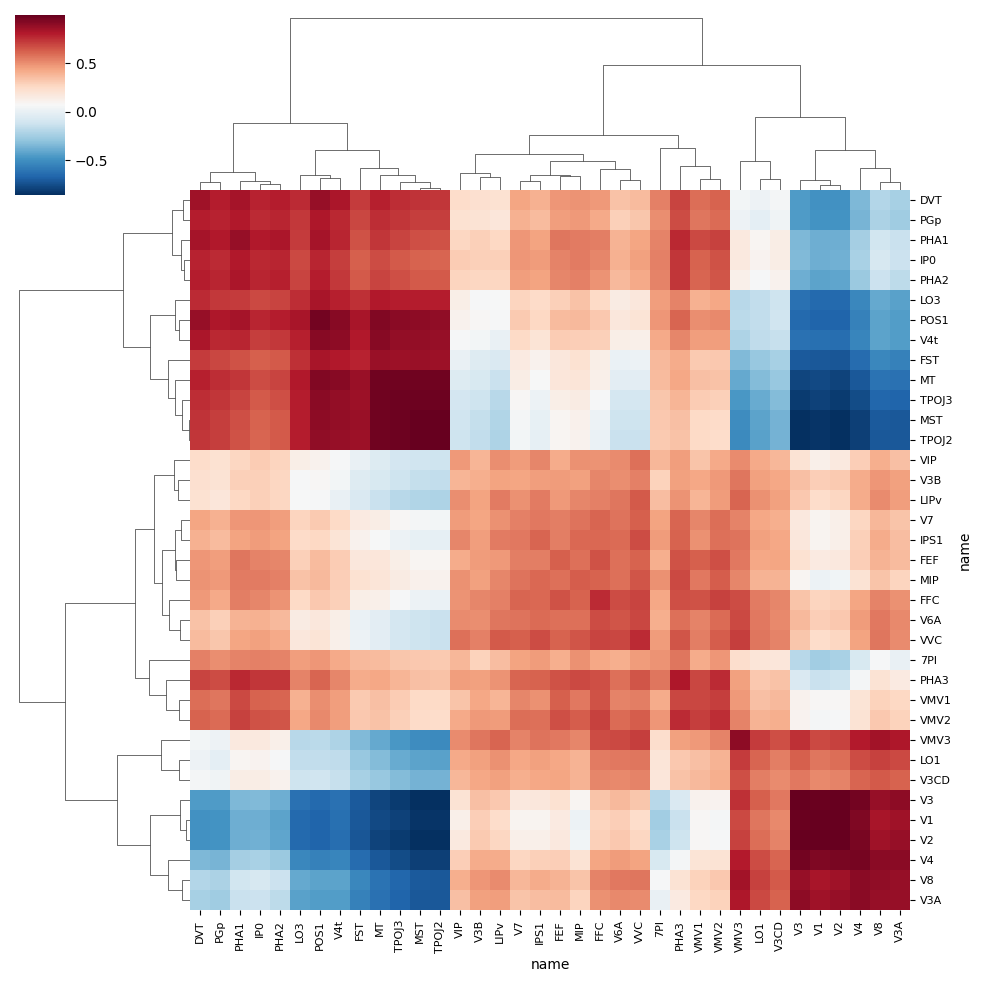

In [278]:
g = sns.clustermap(df_CCt.loc[filtered_rois, filtered_rois], cmap="RdBu_r", xticklabels=True, 
                   yticklabels=True)
# Force to appear al xticks and ytick labels
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=8)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8);



In [294]:
import numpy as np

def compute_centers_of_mass(curves: np.ndarray) -> np.ndarray:
    """
    Compute the center of mass for each curve in a stacked array.

    Parameters:
        curves (np.ndarray): Array of shape (n_curves, n_timepoints).

    Returns:
        np.ndarray: Array of shape (n_curves,) containing centers of mass.
    """
    timepoints = np.arange(curves.shape[1])
    numerators = np.sum(curves * timepoints, axis=1)
    denominators = np.sum(curves, axis=1) + 1e-10  # epsilon avoids division by zero
    return numerators / denominators

df_C2 = df_C.copy()
df_C2 = df_C2.loc[filtered_rois]
max_index = compute_centers_of_mass(df_C2.values) #
#max_index =np.argmax(df_C2.values, axis=1)
df_C2['max_index'] = max_index
df_C2 = df_C2.sort_values("max_index")
df_C2 = df_C2.drop(columns="max_index")

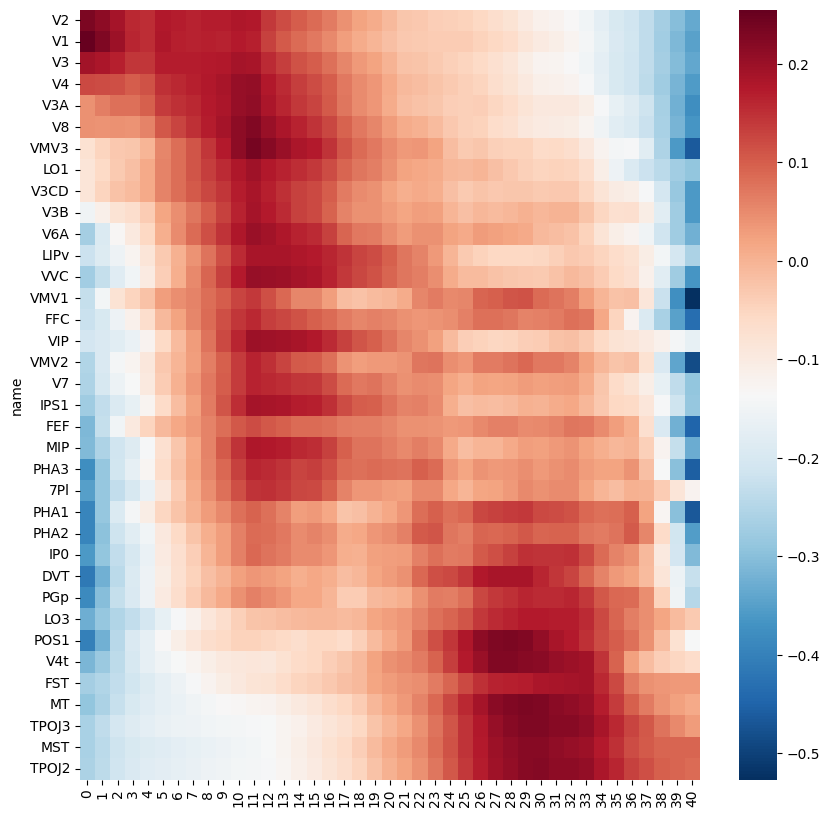

In [295]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
g = sns.heatmap(df_C2, cmap="RdBu_r", xticklabels=True, yticklabels=True, ax=ax)
# Force to appear al xticks and ytick labels
#plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=8)
#plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8);



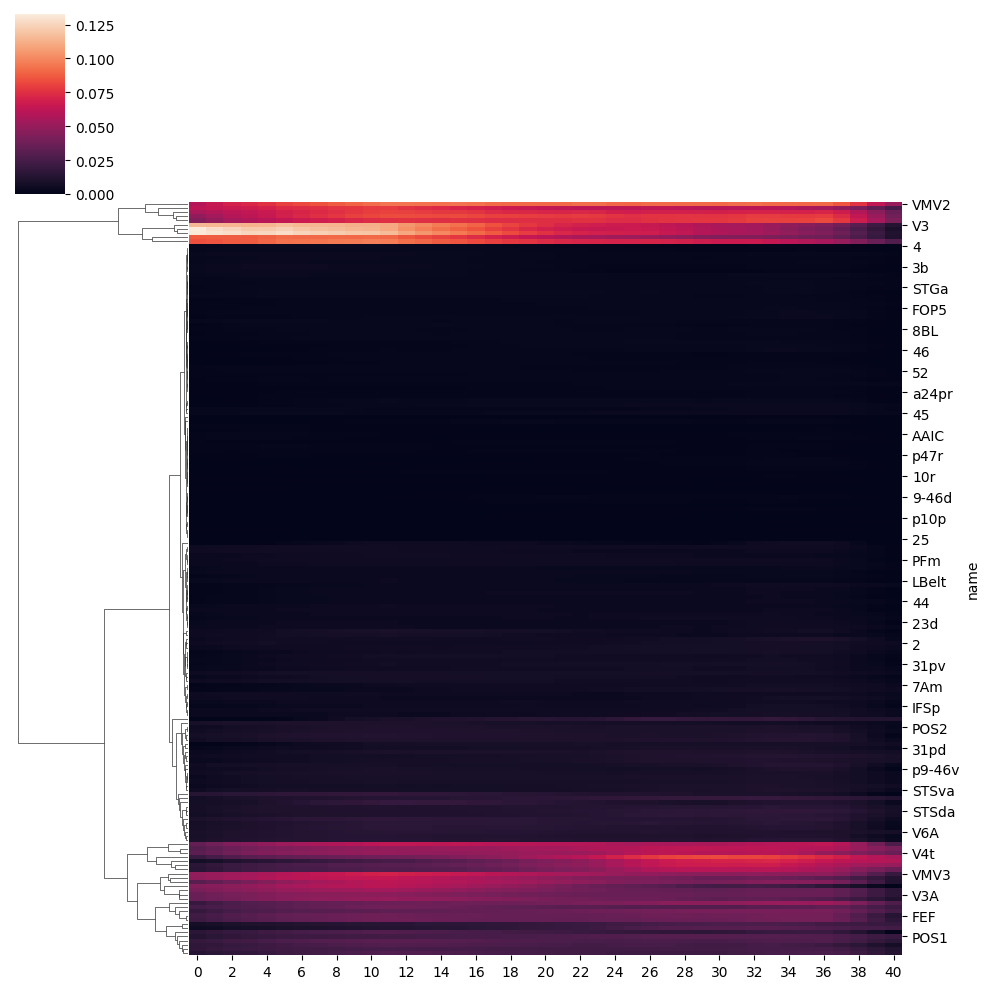